In [20]:
#!pip install Cython

In [21]:
#!pip install pycocotools

In [22]:
import argparse

import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
from val import normalize, pad_width

### Load networks

In [23]:
net = PoseEstimationWithMobileNet() #openpose(bottom up), feature extract backcone : VGG19대신 mobilenet사용
checkpoint = torch.load('./checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)
net.eval()

# network settingsß
stride = 8
upsample_ratio = 4
num_keypoints = Pose.num_kpts
net_input_height_size = 256
pad_value=(0, 0, 0)
img_mean=(128, 128, 128)
img_scale=1/256

### Load Images

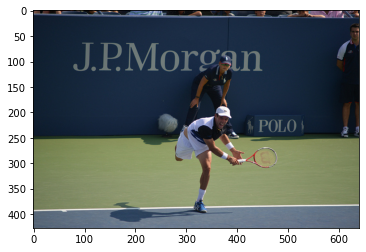

In [24]:
file_names = ['./data/000000000785.jpg', './data/000000000885.jpg', './data/000000003156.jpg', './data/multi_persons.jpg']
img = cv2.imread(file_names[1], cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Inference image

In [25]:
orig_img = img.copy()

height, width, _ = img.shape
scale = net_input_height_size / height

scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
scaled_img = normalize(scaled_img, img_mean, img_scale)
min_dims = [net_input_height_size, max(scaled_img.shape[1], net_input_height_size)]
padded_img, pad = pad_width(scaled_img, stride, pad_value, min_dims)

tensor_img = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).float()

stages_output = net(tensor_img)

stage2_heatmaps = stages_output[-2]
heatmaps = np.transpose(stage2_heatmaps.squeeze().cpu().data.numpy(), (1, 2, 0))
heatmaps = cv2.resize(heatmaps, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)

stage2_pafs = stages_output[-1]
pafs = np.transpose(stage2_pafs.squeeze().cpu().data.numpy(), (1, 2, 0))
pafs = cv2.resize(pafs, (0, 0), fx=upsample_ratio, fy=upsample_ratio, interpolation=cv2.INTER_CUBIC)


### visualize heatmaps

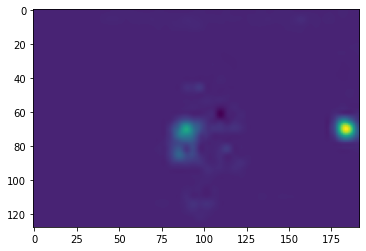

In [26]:
plt.imshow(heatmaps[:, :, 10])

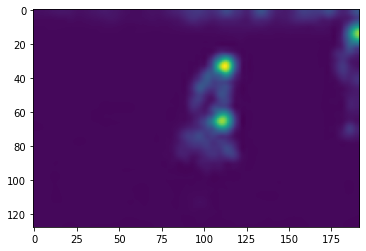

In [27]:
plt.imshow(heatmaps[:, :, :19].sum(axis=-1))

### Post process result

In [28]:
# post process result
total_keypoints_num = 0 #key_point : 관절
all_keypoints_by_type = []
for kpt_idx in range(num_keypoints):  # 19th for bg
    total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs, demo=True)
for kpt_id in range(all_keypoints.shape[0]):
    all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
    all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
current_poses = []
for n in range(len(pose_entries)):
    if len(pose_entries[n]) == 0:
        continue
    pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
    for kpt_id in range(num_keypoints):
        if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
            pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
            pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
    pose = Pose(pose_keypoints, pose_entries[n][18])
    current_poses.append(pose)

### Draw result

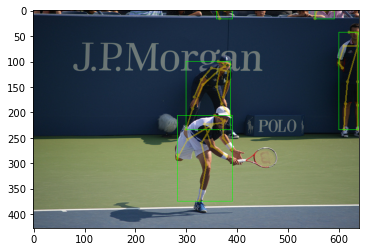

In [29]:
for pose in current_poses:
    pose.draw(img)
img = cv2.addWeighted(orig_img, 0.6, img, 0.4, 0)
for pose in current_poses:
    cv2.rectangle(img, (pose.bbox[0], pose.bbox[1]),
                  (pose.bbox[0] + pose.bbox[2], pose.bbox[1] + pose.bbox[3]), (0, 255, 0))
    
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))